# Transformer 
Transformer from scratch with NumpPy

## Library

In [ ]:
# run if u haven't install the library yet
!pip install numpy
!pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 8.1/8.1 MB 5.6 MB/s eta 0:00:00
     -------------------------------------- 225.2/225.2 kB 4.6 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.3/2.3 MB 5.6 MB/s eta 0:00:00
     ---------------------------------------- 73.8/73.8 kB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 7.0/7.0 MB 3.8 MB/s eta 0:00:00
     ------------------------------------ 113.9/113.9 kB 950.9 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Token Embedding

In [2]:
# make a list of sentences
sentences = [
    "noodle is delicious",
    "i like hot rice",
    "the weather is cold",
    "that rice is cold",
    "i eat hot noodle",
    "good weather today",
    "noodle and rice are food",
    "i eat food",
    "the food is good",
    "the noodle is good"
]
sentences

['noodle is delicious',
 'i like hot rice',
 'the weather is cold',
 'that rice is cold',
 'i eat hot noodle',
 'good weather today',
 'noodle and rice are food',
 'i eat food',
 'the food is good',
 'the noodle is good']

In [3]:
len(sentences)

10

In [4]:
# get words from sentences
words = set()
for sentence in sentences:
    for word in sentence.split():
        words.add(word)

words

{'and',
 'are',
 'cold',
 'delicious',
 'eat',
 'food',
 'good',
 'hot',
 'i',
 'is',
 'like',
 'noodle',
 'rice',
 'that',
 'the',
 'today',
 'weather'}

In [5]:
# map each words with unique id
vocab = {
    "<S>":0, # start of the sentence
    "<E>":1, # end of the sentence
    "<P>":2 # padding/empty word 
}

# map each id to word
rvocab = {
    0:"<S>", # start of the sentence
    1:"<E>", # end of the sentence
    2:"<P>" # padding/empty word 
}

for i, word in enumerate(words, start=3):
    vocab[word] = i
    rvocab[i] = word

vocab # word to id

{'<S>': 0,
 '<E>': 1,
 '<P>': 2,
 'that': 3,
 'eat': 4,
 'cold': 5,
 'food': 6,
 'rice': 7,
 'weather': 8,
 'noodle': 9,
 'and': 10,
 'delicious': 11,
 'good': 12,
 'today': 13,
 'are': 14,
 'like': 15,
 'i': 16,
 'is': 17,
 'hot': 18,
 'the': 19}

In [6]:
rvocab # id to word

{0: '<S>',
 1: '<E>',
 2: '<P>',
 3: 'that',
 4: 'eat',
 5: 'cold',
 6: 'food',
 7: 'rice',
 8: 'weather',
 9: 'noodle',
 10: 'and',
 11: 'delicious',
 12: 'good',
 13: 'today',
 14: 'are',
 15: 'like',
 16: 'i',
 17: 'is',
 18: 'hot',
 19: 'the'}

In [7]:
# fucntion to tokenize the sentence based on our vocab
def tokenize(sentence, vocab, seq_len=5):
    tokens = [vocab.get(word.lower()) for word in sentence.split()]
    return [vocab["<S>"]] + tokens + [vocab["<E>"]] + [vocab["<P>"]]*max(0, seq_len-len(tokens))

In [8]:
# tokenize each sentences
tokenized_sentence = [tokenize(sentence,vocab) for sentence in sentences]
tokenized_sentence

[[0, 9, 17, 11, 1, 2, 2],
 [0, 16, 15, 18, 7, 1, 2],
 [0, 19, 8, 17, 5, 1, 2],
 [0, 3, 7, 17, 5, 1, 2],
 [0, 16, 4, 18, 9, 1, 2],
 [0, 12, 8, 13, 1, 2, 2],
 [0, 9, 10, 7, 14, 6, 1],
 [0, 16, 4, 6, 1, 2, 2],
 [0, 19, 6, 17, 12, 1, 2],
 [0, 19, 9, 17, 12, 1, 2]]

In [9]:
# create embedding for the token
embedding_dimension = 4
embedding_matrix = np.random.rand(len(vocab), embedding_dimension) * 0.01
embedding = embedding_matrix[tokenized_sentence]
embedding

array([[[0.00493459, 0.00870505, 0.00119617, 0.00494898],
        [0.00716407, 0.00969019, 0.00263199, 0.00708115],
        [0.00715719, 0.00760423, 0.00531297, 0.00452547],
        [0.00245709, 0.00497319, 0.00161827, 0.00430758],
        [0.0092685 , 0.005001  , 0.00603442, 0.0079616 ],
        [0.00774071, 0.00920854, 0.00219558, 0.00735737],
        [0.00774071, 0.00920854, 0.00219558, 0.00735737]],

       [[0.00493459, 0.00870505, 0.00119617, 0.00494898],
        [0.00392364, 0.00772141, 0.00315789, 0.00199828],
        [0.00715888, 0.00893833, 0.00911925, 0.00288404],
        [0.00862911, 0.00168714, 0.00154041, 0.00502483],
        [0.00315532, 0.0097328 , 0.00795287, 0.00960759],
        [0.0092685 , 0.005001  , 0.00603442, 0.0079616 ],
        [0.00774071, 0.00920854, 0.00219558, 0.00735737]],

       [[0.00493459, 0.00870505, 0.00119617, 0.00494898],
        [0.00841154, 0.00773769, 0.00316496, 0.00285416],
        [0.00099759, 0.00029987, 0.00923337, 0.00398142],
        [0

In [10]:
embedding.shape # (batch, seq_len, d_model)

(10, 7, 4)

## Positional Encoding

In [11]:
# function for the sinusoidal positional encoding
def sinusoidalPositionalEncoding(seq_len, d, n=10000):
    encoding = np.zeros((seq_len, d))
    for pos in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            theta = pos/denominator
            encoding[pos, 2*i] = np.sin(theta)
            encoding[pos, 2*i+1] = np.cos(theta)
    return encoding

In [12]:
# get token length & embedding dimension
token_len = len(tokenized_sentence[0])
embedding_dimension = embedding.shape[-1]

# create positional encoding based on token_len & embedding_dimension
positional_enc = sinusoidalPositionalEncoding(token_len, embedding_dimension)

# add positional encoding to embedding
embedding_with_positional_enc = embedding + positional_enc
embedding_with_positional_enc

array([[[ 0.00493459,  1.00870505,  0.00119617,  1.00494898],
        [ 0.84863506,  0.54999249,  0.01263183,  1.00703115],
        [ 0.91645462, -0.40854261,  0.02531164,  1.00432548],
        [ 0.1435771 , -0.9850193 ,  0.03161377,  1.00385761],
        [-0.74753399, -0.64864262,  0.04602376,  1.0071617 ],
        [-0.95118356,  0.29287073,  0.05217475,  1.00610763],
        [-0.27167479,  0.96937883,  0.06215959,  1.00555791]],

       [[ 0.00493459,  1.00870505,  0.00119617,  1.00494898],
        [ 0.84539462,  0.54802371,  0.01315772,  1.00194828],
        [ 0.91645631, -0.4072085 ,  0.02911791,  1.00268404],
        [ 0.14974912, -0.98830536,  0.03153591,  1.00457486],
        [-0.75364717, -0.64391082,  0.0479422 ,  1.0088077 ],
        [-0.94965577,  0.28866318,  0.05601359,  1.00671186],
        [-0.27167479,  0.96937883,  0.06215959,  1.00555791]],

       [[ 0.00493459,  1.00870505,  0.00119617,  1.00494898],
        [ 0.84988253,  0.54804   ,  0.01316479,  1.00280416],
    

In [13]:
embedding_with_positional_enc.shape # (batch, seq_len, d_model)

(10, 7, 4)

## Causal Masking

In [14]:
mask_len = embedding_with_positional_enc.shape[1]
causal_mask = np.triu(np.ones((mask_len, mask_len)) * -1e9, k=1)
causal_mask

array([[ 0.e+00, -1.e+09, -1.e+09, -1.e+09, -1.e+09, -1.e+09, -1.e+09],
       [ 0.e+00,  0.e+00, -1.e+09, -1.e+09, -1.e+09, -1.e+09, -1.e+09],
       [ 0.e+00,  0.e+00,  0.e+00, -1.e+09, -1.e+09, -1.e+09, -1.e+09],
       [ 0.e+00,  0.e+00,  0.e+00,  0.e+00, -1.e+09, -1.e+09, -1.e+09],
       [ 0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00, -1.e+09, -1.e+09],
       [ 0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00, -1.e+09],
       [ 0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00]])

## Scaled Dot-Product Attention

In [15]:
def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x/np.sum(e_x, axis=-1, keepdims=True)

In [16]:
# test softmax with random input
for i in range(10):
    random_input = np.random.randn(5)
    softmax_output = softmax(random_input, axis=-1)
    # use np.isclose to handle floating point precision issues
    assert np.isclose(softmax_output.sum(), 1.0), "sum of all softmax output must equal to 1"
    assert softmax_output.min() >= 0 and softmax_output.max() <= 1, "softmax output must be around 0<=x<=1"
"Softmax test passed"

'Softmax test passed'

In [17]:
# function for scaled dot product attention
def scaled_dot_product_attention(Q, K, V, mask=None, multi=False):
    d_k = Q.shape[-1]
    scores = np.matmul(Q, (K.transpose(0, 1, 3, 2) if multi is True else K.transpose(0, 2, 1))) / np.sqrt(d_k)
    if mask is not None:
        scores+=mask
    weights = softmax(scores)
    output = np.matmul(weights, V)
    return output, weights

In [18]:
# test single head function 
W_Q = np.random.rand(4, 4)*0.01
W_K = np.random.rand(4, 4)*0.01
W_V = np.random.rand(4, 4)*0.01

Q = np.matmul(embedding_with_positional_enc, W_Q)
K = np.matmul(embedding_with_positional_enc, W_K)
V = np.matmul(embedding_with_positional_enc, W_V)

In [19]:
Q

array([[[ 0.00572305,  0.00539899,  0.01645045,  0.00869499],
        [ 0.00930225,  0.01282342,  0.01712559,  0.007965  ],
        [ 0.00507191,  0.01209584,  0.01105672,  0.00255743],
        [-0.00306871,  0.00389914,  0.00389   , -0.00252254],
        [-0.0074446 , -0.00401562,  0.00242967, -0.00245469],
        [-0.00413773, -0.00453321,  0.00789829,  0.0026455 ],
        [ 0.00394116,  0.00299544,  0.01544119,  0.00819312]],

       [[ 0.00572305,  0.00539899,  0.01645045,  0.00869499],
        [ 0.0092695 ,  0.01277264,  0.01705337,  0.00793523],
        [ 0.00509702,  0.01210964,  0.01107767,  0.00258243],
        [-0.00304254,  0.00395548,  0.00390098, -0.00252647],
        [-0.00745214, -0.00405145,  0.00246478, -0.00242518],
        [-0.00412798, -0.00450434,  0.00791048,  0.00264775],
        [ 0.00394116,  0.00299544,  0.01544119,  0.00819312]],

       [[ 0.00572305,  0.00539899,  0.01645045,  0.00869499],
        [ 0.00930103,  0.01281877,  0.01708116,  0.00794777],
    

In [20]:
K

array([[[ 0.01209403,  0.01076771,  0.01358567,  0.01336577],
        [ 0.00951244,  0.0099807 ,  0.01512264,  0.01371023],
        [ 0.00344963,  0.00447827,  0.00843089,  0.00816341],
        [-0.00047256, -0.00064952, -0.00028382,  0.00188982],
        [ 0.00146376, -0.000594  , -0.00274765,  0.0009022 ],
        [ 0.00744021,  0.00453945,  0.00317984,  0.0060038 ],
        [ 0.01204241,  0.01009235,  0.01224518,  0.01270032]],

       [[ 0.01209403,  0.01076771,  0.01358567,  0.01336577],
        [ 0.00947275,  0.00993911,  0.01506362,  0.01365525],
        [ 0.00346709,  0.0044892 ,  0.00846502,  0.0081955 ],
        [-0.00048783, -0.00065198, -0.00026931,  0.00189624],
        [ 0.00151031, -0.00056636, -0.0027205 ,  0.00093884],
        [ 0.00743549,  0.00453174,  0.00319494,  0.00602358],
        [ 0.01204241,  0.01009235,  0.01224518,  0.01270032]],

       [[ 0.01209403,  0.01076771,  0.01358567,  0.01336577],
        [ 0.00947921,  0.00995334,  0.01509475,  0.01367768],
    

In [21]:
V

array([[[ 4.55845405e-03,  1.36000217e-02,  4.00039484e-03,
          8.20650945e-03],
        [ 8.93756347e-03,  1.00240005e-02,  4.84340853e-03,
          1.11623973e-02],
        [ 6.78752104e-03,  1.64488420e-03,  1.73397552e-03,
          7.57614445e-03],
        [ 8.61782493e-05, -3.79796033e-03, -2.47141869e-03,
          7.63033900e-04],
        [-4.88278193e-03, -1.23111172e-03, -3.86715552e-03,
         -2.87827951e-03],
        [-3.65201238e-03,  6.96050430e-03, -1.20653944e-03,
         -1.00479953e-04],
        [ 2.73216152e-03,  1.32731874e-02,  3.07655400e-03,
          6.63916232e-03]],

       [[ 4.55845405e-03,  1.36000217e-02,  4.00039484e-03,
          8.20650945e-03],
        [ 8.90273741e-03,  9.98251786e-03,  4.82479133e-03,
          1.11171124e-02],
        [ 6.79569751e-03,  1.65853496e-03,  1.73808838e-03,
          7.58633254e-03],
        [ 1.19322821e-04, -3.82061857e-03, -2.46467044e-03,
          7.87247171e-04],
        [-4.90385193e-03, -1.17994999e-03

In [22]:
Q.shape # (batch, seq_len, d_model)

(10, 7, 4)

In [23]:
K.shape # (batch, seq_len, d_model)

(10, 7, 4)

In [24]:
V.shape # (batch, seq_len, d_model)

(10, 7, 4)

In [25]:
# test without masking mask
single_output, single_weights = scaled_dot_product_attention(Q, K, V)
(single_output, single_weights)

(array([[[0.00208138, 0.00578252, 0.00087305, 0.00448165],
         [0.00208145, 0.00578268, 0.00087313, 0.00448174],
         [0.0020813 , 0.00578242, 0.00087299, 0.00448156],
         [0.00208105, 0.00578197, 0.00087277, 0.00448126],
         [0.00208096, 0.00578177, 0.00087268, 0.00448113],
         [0.00208109, 0.00578199, 0.00087279, 0.00448129],
         [0.00208133, 0.00578244, 0.00087301, 0.00448159]],
 
        [[0.00208032, 0.00577923, 0.00087056, 0.00448032],
         [0.00208039, 0.00577939, 0.00087063, 0.00448041],
         [0.00208024, 0.00577913, 0.0008705 , 0.00448023],
         [0.00208   , 0.00577868, 0.00087028, 0.00447993],
         [0.0020799 , 0.00577848, 0.00087019, 0.0044798 ],
         [0.00208003, 0.0057787 , 0.0008703 , 0.00447996],
         [0.00208028, 0.00577914, 0.00087052, 0.00448026]],
 
        [[0.00207623, 0.00576618, 0.00086558, 0.00447356],
         [0.00207631, 0.00576634, 0.00086565, 0.00447366],
         [0.00207615, 0.00576607, 0.00086552, 0.00

In [26]:
# test with mask
single_masked_output, single_masked_weights = scaled_dot_product_attention(Q, K, V, mask=causal_mask)
single_masked_output

array([[[0.00455845, 0.01360002, 0.00400039, 0.00820651],
        [0.00674801, 0.01181201, 0.0044219 , 0.00968445],
        [0.00676118, 0.00842318, 0.00352598, 0.00898173],
        [0.00509245, 0.00536778, 0.00202661, 0.00692705],
        [0.0030973 , 0.00404779, 0.00084776, 0.00496585],
        [0.00197258, 0.00453345, 0.0005055 , 0.00412164],
        [0.00208133, 0.00578244, 0.00087301, 0.00448159]],

       [[0.00455845, 0.01360002, 0.00400039, 0.00820651],
        [0.00673059, 0.01179127, 0.00441259, 0.00966181],
        [0.00675229, 0.0084139 , 0.00352115, 0.00897003],
        [0.00509408, 0.00535516, 0.00202467, 0.00692433],
        [0.00309439, 0.00404793, 0.00084616, 0.00496305],
        [0.00197134, 0.00452961, 0.00050259, 0.00412009],
        [0.00208028, 0.00577914, 0.00087052, 0.00448026]],

       [[0.00455845, 0.01360002, 0.00400039, 0.00820651],
        [0.00674629, 0.01179448, 0.00441928, 0.00967638],
        [0.00674195, 0.00839151, 0.00350997, 0.00895753],
        [0

In [27]:
single_masked_weights

array([[[1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.50000063, 0.49999937, 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.33334416, 0.33334337, 0.33331246, 0.        , 0.        ,
         0.        , 0.        ],
        [0.25000081, 0.25000206, 0.25000019, 0.24999694, 0.        ,
         0.        , 0.        ],
        [0.19999271, 0.19999523, 0.20000169, 0.20000609, 0.20000427,
         0.        , 0.        ],
        [0.16666833, 0.1666706 , 0.16666915, 0.16666532, 0.16666279,
         0.16666381, 0.        ],
        [0.1428701 , 0.1428711 , 0.14285759, 0.1428421 , 0.14283937,
         0.14285167, 0.14286807]],

       [[1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.50000092, 0.49999908, 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.33334424, 0.3333432 , 0.33331256, 0.        , 0.        ,
  

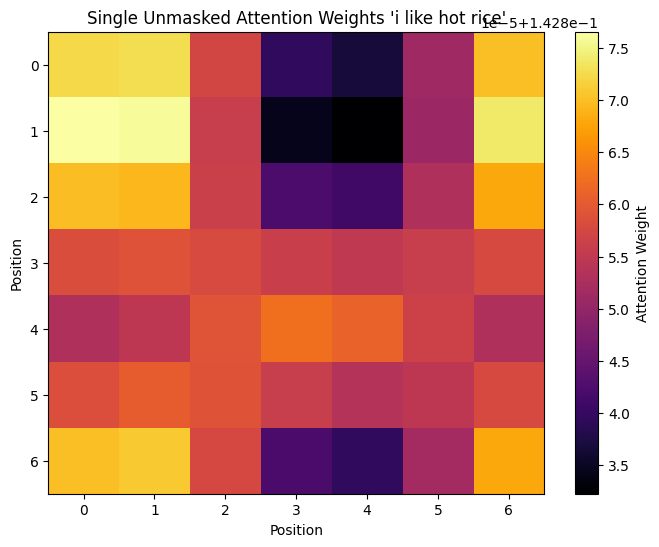

In [28]:
s_idx = 1
v_sentence = sentences[s_idx]

# plot weight before being masked
plt.figure(figsize=(8, 6))
plt.imshow(single_weights[s_idx], cmap='inferno', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Position')
plt.ylabel('Position')
plt.title(f"Single Unmasked Attention Weights '{v_sentence}'")

plt.show()

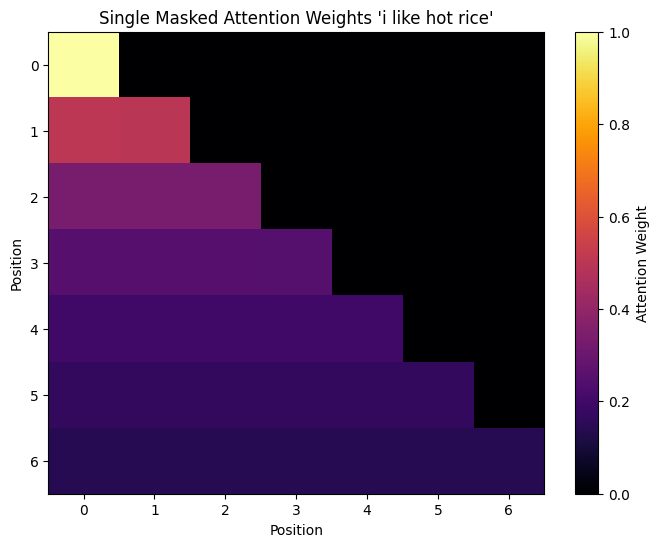

In [29]:
# plot weight after being masked
plt.figure(figsize=(8, 6))
plt.imshow(single_masked_weights[s_idx], cmap='inferno', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Position')
plt.ylabel('Position')
plt.title(f"Single Masked Attention Weights '{v_sentence}'")

plt.show()

In [30]:
single_masked_output.shape # (batch, seq_len, d_model)

(10, 7, 4)

In [31]:
single_masked_weights.shape # (batch, seq_len, d_model)

(10, 7, 7)

## Multi-Head Attention 

In [32]:
def split_heads(x, num_heads):
    batch_size, seq_len, d_model = x.shape
    head_dim = d_model // num_heads
    x = x.reshape(batch_size, seq_len, num_heads, head_dim)
    return x.transpose(0, 2, 1, 3)  

In [33]:
def combine_heads(x):
    batch_size, num_heads, seq_len, head_dim = x.shape
    return x.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, num_heads * head_dim)

In [34]:
# function for multi head attention
def multi_head_attention(X, num_heads):
    assert num_heads>0, "number of heads must be more than 0"
    
    d_model = X.shape[-1]
    assert d_model % num_heads == 0, "input dimension must be divisible by number of heads"

    # init random Q, V, K
    W_Q = np.random.randn(d_model, d_model) * 0.01
    W_K = np.random.randn(d_model, d_model) * 0.01
    W_V = np.random.randn(d_model, d_model) * 0.01

    Q = np.matmul(X, W_Q)  # [batch, seq_len, d_model]
    K = np.matmul(X, W_K)
    V = np.matmul(X, W_V)

    # split into heads
    Q = split_heads(Q, num_heads)  # [batch, heads, seq_len, head_dim]
    K = split_heads(K, num_heads)
    V = split_heads(V, num_heads)

    # attention for each head
    attention_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask=causal_mask, multi=True) # use causal mask & add multi=True to use the correct transpose function

    # combine heads
    output = combine_heads(attention_output)  

    return output, attn_weights

In [35]:
# get multi head attention output & weights based on our embedding input
heads = 2
out, weights = multi_head_attention(embedding_with_positional_enc, heads)
(out, weights)

(array([[[-0.01674241, -0.00119657, -0.00110874,  0.00309597],
         [-0.0188512 ,  0.00148085,  0.00133716,  0.00479573],
         [-0.01941421, -0.00058192,  0.00709624,  0.00216163],
         [-0.01855497, -0.00536343,  0.01277135, -0.0026333 ],
         [-0.01720324, -0.00966508,  0.01560376, -0.00665626],
         [-0.0162782 , -0.01133795,  0.01510603, -0.00805606],
         [-0.01623874, -0.01039461,  0.01295296, -0.00710103]],
 
        [[-0.01674241, -0.00119657, -0.00110874,  0.00309597],
         [-0.01880508,  0.00148137,  0.00131862,  0.00478263],
         [-0.01939097, -0.00056765,  0.00706365,  0.00213512],
         [-0.01854752, -0.00534487,  0.01275834, -0.00264726],
         [-0.01720158, -0.00965797,  0.0155851 , -0.00668024],
         [-0.016287  , -0.01133568,  0.01509971, -0.00809496],
         [-0.01624628, -0.01039267,  0.01294754, -0.00713437]],
 
        [[-0.01674241, -0.00119657, -0.00110874,  0.00309597],
         [-0.01882374,  0.00150318,  0.00131861, 

In [36]:
out.shape # (batch, seq_len, d_model)

(10, 7, 4)

In [37]:
weights.shape # (batch, num_heads, seq_len, seq_len)

(10, 2, 7, 7)

## Feed-Forward Network

In [38]:
class FeedForward:
    def __init__(self, d_model, d_ff=16):
        self.W1 = np.random.randn(d_model, d_ff) * 0.01
        self.b1 = np.zeros(d_ff)
        self.W2 = np.random.randn(d_ff, d_model) * 0.01
        self.b2 = np.zeros(d_model)

    def __call__(self, x):
        hidden = np.maximum(0, x @ self.W1 + self.b1)  # ReLU
        return hidden @ self.W2 + self.b2

In [39]:
ffn = FeedForward(embedding_dimension) # init the ffn

In [40]:
ffn_out = ffn(out)
ffn_out

array([[[-9.97643881e-06,  2.73080665e-06, -3.82547069e-06,
         -9.02742121e-06],
        [-1.08940019e-05,  3.02228008e-06, -3.95198099e-06,
         -1.06633501e-05],
        [-1.33985840e-05,  4.49358604e-06, -3.22943437e-06,
         -1.22756298e-05],
        [-1.59827788e-05,  6.16340147e-06, -3.01836314e-06,
         -1.32694233e-05],
        [-1.78129656e-05,  7.07766051e-06, -2.68014394e-06,
         -1.37800834e-05],
        [-1.77037067e-05,  7.26395201e-06, -2.72706348e-06,
         -1.34595780e-05],
        [-1.64955003e-05,  6.90216718e-06, -2.99513534e-06,
         -1.28841887e-05]],

       [[-9.97643881e-06,  2.73080665e-06, -3.82547069e-06,
         -9.02742121e-06],
        [-1.08593998e-05,  3.01251461e-06, -3.94327919e-06,
         -1.06319722e-05],
        [-1.33568701e-05,  4.48845010e-06, -3.23213372e-06,
         -1.22542270e-05],
        [-1.59591460e-05,  6.16071243e-06, -3.01795565e-06,
         -1.32617884e-05],
        [-1.77928291e-05,  7.07850266e-06

In [41]:
ffn_out.shape # (batch, seq_len, d_model)

(10, 7, 4)

## Layer Normalization

In [42]:
def layer_norm(x, eps=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    return (x - mean) / (std + eps)

## Residual Connection

In [43]:
# Residual + LayerNorm after multi-head attention
attn_residual = layer_norm(embedding_with_positional_enc + out)

# Residual + LayerNorm after feed-forward
ffn_residual = layer_norm(attn_residual + ffn_out)

ffn_residual

array([[[-1.01170234e+00,  9.99441130e-01, -9.88226632e-01,
          1.00048784e+00],
        [ 6.05005702e-01, -1.33426478e-01, -1.55960304e+00,
          1.08802382e+00],
        [ 8.70039593e-01, -1.33514651e+00, -5.89713132e-01,
          1.05482005e+00],
        [ 1.13276141e-01, -1.46698471e+00, -9.55771724e-04,
          1.35466434e+00],
        [-9.56201487e-01, -8.05301130e-01,  2.15275888e-01,
          1.54622673e+00],
        [-1.50995258e+00,  2.65358426e-01, -3.91833887e-02,
          1.28377754e+00],
        [-1.29830153e+00,  9.37456923e-01, -6.47368499e-01,
          1.00821311e+00]],

       [[-1.01170234e+00,  9.99441130e-01, -9.88226632e-01,
          1.00048784e+00],
        [ 6.06217470e-01, -1.32886340e-01, -1.56007261e+00,
          1.08674148e+00],
        [ 8.70729062e-01, -1.33758867e+00, -5.86234921e-01,
          1.05309453e+00],
        [ 1.20506540e-01, -1.46949400e+00, -2.32750553e-03,
          1.35131497e+00],
        [-9.63923572e-01, -7.97934819e-01

In [44]:
ffn_residual.shape # (batch, seq_len, d_model)

(10, 7, 4)

## Output Layer

In [45]:
# Suppose ffn_residual is your final transformer block output
vocab_size = len(vocab)
d_model = ffn_residual.shape[-1]
W_out = np.random.randn(d_model, vocab_size) * 0.01
b_out = np.zeros(vocab_size)

# Project to vocabulary size (logits for each token)
logits = ffn_residual @ W_out + b_out
logits.shape  # (batch, seq_len, vocab_size)

(10, 7, 20)

In [46]:
logits

array([[[-0.01620819,  0.02332415, -0.00850888, ..., -0.00405951,
          0.00911029,  0.01566282],
        [-0.00120292,  0.01268439, -0.01102106, ..., -0.01424707,
         -0.01910101, -0.01618867],
        [ 0.02631841,  0.0218588 , -0.00732461, ..., -0.01102486,
         -0.00865035, -0.04162971],
        ...,
        [ 0.02807347,  0.053816  , -0.00680181, ..., -0.00133105,
          0.0318021 , -0.02660695],
        [ 0.00600732,  0.04510129, -0.00644085, ...,  0.00116498,
          0.0324106 ,  0.00043909],
        [-0.01237367,  0.02870985, -0.00730475, ..., -0.00129635,
          0.01786656,  0.01573608]],

       [[-0.01620819,  0.02332415, -0.00850888, ..., -0.00405951,
          0.00911029,  0.01566282],
        [-0.00122641,  0.01263465, -0.01101648, ..., -0.01424913,
         -0.01913703, -0.01617126],
        [ 0.02637257,  0.02184357, -0.00730347, ..., -0.01100528,
         -0.00862652, -0.04166616],
        ...,
        [ 0.02795328,  0.05382935, -0.00679031, ..., -

In [53]:
# get random sentence from sentences list
sentence_idx = 2
print(f"The sentence is {sentences[sentence_idx]}")
sentence_token = tokenized_sentence[sentence_idx]

# get last word in sentence (not <P>/<E>)
idx = len(sentence_token)-1
while(sentence_token[idx] <= 2):
    idx-=1

# get the sentence that we want to predict
predicted_sentence = [rvocab[sentence_token[i]] for i in range(idx)]

# based on the sentence the word should be this
print(f"Based on the sentence, the last word of sequence {predicted_sentence} should be {rvocab[sentence_token[idx]]}")

idx-=1 # do this to exclude the last word because we want to predict what the last word are

# get the logits of the same sentence and exclude special words in vocab like (<S>, <P>, <E>)
last_logits_token = logits[sentence_idx, idx][3:]

# get the next token probability
probs = softmax(last_logits_token)

# get all word exceb special words
word_list = [rvocab[i] for i in range(3, vocab_size)]

# print the probability of each words
for i in range(len(probs)):
    print(f"Word: '{word_list[i]}' have a probability of {probs[i]}")

The sentence is the weather is cold
Based on the sentence, the last word of sequence ['<S>', 'the', 'weather', 'is'] should be cold
Word: 'that' have a probability of 0.0576797675955322
Word: 'eat' have a probability of 0.058727158659036355
Word: 'cold' have a probability of 0.05853244849157253
Word: 'food' have a probability of 0.06062220702907506
Word: 'rice' have a probability of 0.05899629171821492
Word: 'weather' have a probability of 0.058204330932901796
Word: 'noodle' have a probability of 0.058705534367915646
Word: 'and' have a probability of 0.06058144344834361
Word: 'delicious' have a probability of 0.05815764130119058
Word: 'good' have a probability of 0.060870059768790896
Word: 'today' have a probability of 0.05850722997620194
Word: 'are' have a probability of 0.05830755880775142
Word: 'like' have a probability of 0.0586737821000586
Word: 'i' have a probability of 0.05774787678190003
Word: 'is' have a probability of 0.05890065896911217
Word: 'hot' have a probability of 0.06

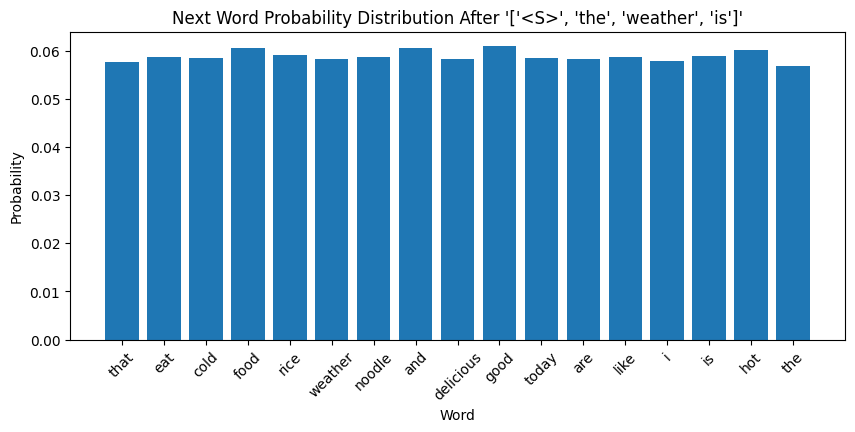

In [56]:
plt.figure(figsize=(10, 4))
plt.bar(word_list, probs)
plt.xlabel('Word')
plt.ylabel('Probability')
plt.title(f"Next Word Probability Distribution After '{predicted_sentence}'")
plt.xticks(rotation=45)
plt.show()